# FDA Anomaly Classification with XGBoost

## Table of Contents

* [Intoduction](#first-bullet)
* [The Data Used](#second-bullet)
* [The Algorithm Used](#third-bullet)
* [Data Cleaning and Feature Engineering Method](#fourth-bullet)
* [Analysis](#fifth1a-bullet)
* [Bayesian Hyperarameter Search](#fifth-bullet)
* [Analysis of Results](#sixth-bullet)
* [Feature Importance](#seventh-bullet)

### Introduction <a class="anchor" id="first-bullet"></a>

**Cloud compute used:** Google Colab <br>
**Runtime:** Python 3.11, TPU w/ High-RAM <br>
**Libraries:** xgboost, hyperopt, matplotlib, seaborn, scikit-learn, pandas, numpy <br>
<br>
After exploring the data, my initial thought was that this would be the right scenario to use an anomaly centered algorithm because of the evident class imbalance between import refusals/recons and accepted imports. But the training time for the Anomaly detection/classification algorithms that I attempted (Isolation Forests, XGBOD) were longer than anticipated.<br>
<br>
I decided on using the XGBoost ensemble classifier because of the following: <br>

* A proven track record for accuracy<br>
* The API is optimized for fast training<br>
<br>
Most ML classification methods suffer at classifiying with extremely imbalanced dataset. After proper tuning, XGBoost seems to not suffer in these type of scenarios.

### The Data Used <a class="anchor" id="second-bullet"></a>

#### Dimensions
**Data Observation Count (N):** 3,291,851 <br>
**Training set size:** 2,205,540 <br>
**Validation set size:** 543,155 <br>
**Test set size:** 543,156 <br>
<br>
**Feature size:** 12 <br>
**Feature Details:** <br>
    * "submission_disposition_time_diff_days" - The difference in days between disposition date and submission date <br>
    * "Division of Northeast Imports" - Dummy variable of port of entry <br>
    * "Division of Northern Border Imports" - Dummy variable of port of entry <br>
    * "Division of Southeast Imports" - Dummy variable of port of entry <br>
    * "Division of Southwest Imports" - Dummy variable of port of entry <br>
    * "Division of West Coast Imports" - Dummy variable of port of entry <br>
    * "product_code_indust_encoded" - Feature engineering by frequency of category <br>
    * "product_code_class_encoded" - Feature engineering by frequency of category <br>
    * "product_code_subclass_encoded" - Feature engineering by frequency of category <br>
    * "product_code_product_grp_encoded" - Feature engineering by frequency of category <br>
    * "product_code_pic_encoded" - Feature engineering by frequency of category <br>
    * "product_code_indust_encoded" - Feature engineering by frequency of category <br>
    * "product_code_main_fei_encoded" - Feature engineering by frequency of category <br>

**Years of Data:** 2020,2021,2022,2023 <br>
**Representation of Division of Northeast Imports (N):** 324,061
**Representation of Division of Northeast Imports (N):** 916,205
**Representation of Division of Southeast Imports (N):** 82,304
**Representation of Division of Southwest Imports (N):** 1,700,245
**Representation of Division of Southwest Imports (N):** 269,036

### The Algorithm Used <a class="anchor" id="third-bullet"></a>

#### XGBoost

XGBoost is a robust and powerful machine learning method that has earned a reputation in the data science community for winning many Kaggle competitions. Created in 2014 by Carnegie Mellon professor Tianqi Chen, XGBoost is an ensemble method (the use of multiple models, usually referred to as "weak learners" that as a whole contribute to one accurate and robust classifier/regressor) that uses gradient boosting to correct for previous model errors as the ensemble is generated sequentially. <br>
<br>
Popularly used in the Python programming language, XGBoost can also be used across many other languages like C++, Java, R, Julia, etc. 

### Data Cleaning and Feature Engineering <a class="anchor" id="fourth-bullet"></a>

#### Removing Columns <br>

<br>

Certain columns were removed from the dataset because of their non-relevance to the machine learning task. Those columns were: <br>
<br>
* 'Manufacturer Line1 Address'
* 'Manufacturer Line2 Address'
* 'Filer Line1 Address'
* 'Filer Line2 Address'
* 'Shipment ID'
* 'Arrival Date',
* 'Submission Date'
* 'Filer Legal Name'
* 'Final Disposition Date'
* 'Filer Zip Code'
* 'Filer FEI Number' <br>


#### Feature Engineering <br>

##### Dummy Variables: <br>
Columns with a small amount of categories (~< 5) were candidates to convert to dummy variables. The "Port of Entry Division" column was the only one converted for this task. <br>

##### Frequency of Category: <br>
To handle the columns with a large amount of categories, I used "Frequency Encoding". This method aims to ween down the amount of categories while capturing the importance of a certain category based on how frequent it appears in the dataset. The following columns were converted with this method: <br>

* 'Product Code - Industry'
* 'Product Code - Class'
* 'Product Code - Subclass'
* 'Product Code - PIC'
* 'Product Code - Product Group'
* 'Manufacturer FEI Number'

##### The Predictor (Y variable): <br>
The predictor variable is a binary (0 for ACCEPTED import, 1 for REFUSED/RECON import). 

##### Final dataset: <br>
In the end, the followin features/columns remained for the final dataset: <br>

* 'submission_disposition_time_diff_days'
* 'Division of Northeast Imports'
* 'Division of Northern Border Imports'
* 'Division of Southeast Imports'
* 'Division of Southwest Imports'
* 'Division of West Coast Imports'
* 'product_code_indust_encoded'
* 'product_code_class_encoded'
* 'product_code_subclass_encoded'
* 'product_code_pic_encoded'
* 'product_code_product_grp_encoded'
* 'product_code_man_fei_encoded'
* 'y'

### Analysis <a class="anchor" id="fifth1a-bullet"></a>

In [ ]:
!pip install xgboost
!pip install hyperopt
!pip install seaborn
!pip install matplotlib

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from hyperopt import hp, fmin, tpe, Trials
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import hyperopt
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls drive/MyDrive/Berkeley/anomaly_detection/

MAIN_FINAL.csv


In [5]:
MAIN_DIR = 'drive/MyDrive/Berkeley/anomaly_detection/'

In [6]:
df = pd.read_csv(MAIN_DIR + 'MAIN_FINAL.csv')
df = df.dropna()

In [7]:
X = df[['submission_disposition_time_diff_days',
       'Division of Northeast Imports', 'Division of Northern Border Imports',
       'Division of Southeast Imports', 'Division of Southwest Imports',
       'Division of West Coast Imports', 'product_code_indust_encoded',
       'product_code_class_encoded', 'product_code_subclass_encoded',
       'product_code_pic_encoded', 'product_code_product_grp_encoded',
       'product_code_man_fei_encoded']]
y = df['y']

In [8]:
X.isna().sum()

submission_disposition_time_diff_days    0
Division of Northeast Imports            0
Division of Northern Border Imports      0
Division of Southeast Imports            0
Division of Southwest Imports            0
Division of West Coast Imports           0
product_code_indust_encoded              0
product_code_class_encoded               0
product_code_subclass_encoded            0
product_code_pic_encoded                 0
product_code_product_grp_encoded         0
product_code_man_fei_encoded             0
dtype: int64

In [9]:
#Train - Validation - Test split
X_train, X_2, y_train, y_2 = train_test_split(X,y,
                                              test_size=0.33,
                                              stratify=y,
                                              random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_2, y_2,
                                               test_size=0.5,
                                               stratify=y_2,
                                               random_state=42)

In [25]:
X_train.shape

(2205540, 12)

In [26]:
X_val.shape

(543155, 12)

In [27]:
X_test.shape

(543156, 12)

In [11]:
#converting dataframes to DMatrix data structures for speed

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

### Bayesian Hyperparameter Search <a class="anchor" id="fifth-bullet"></a> <br>

Hyperopt is a Python library designed for hyperparameter optimization, specifically for machine learning models. It automates the process of tuning hyperparameters by searching for the optimal set of hyperparameters within a specified search space.

**Key features of Hyperopt include:**

* Optimization Algorithms: Hyperopt provides different optimization algorithms such as Random Search, Tree of Parzen Estimators (TPE), and Adaptive TPE (ATPE) to efficiently search the hyperparameter space.

* Modular Design: It offers a modular design that allows users to define a search space for hyperparameters using various distributions (e.g., uniform, normal, log-normal) for both discrete and continuous parameters.

* Integration with Machine Learning Libraries: Hyperopt can seamlessly integrate with popular machine learning libraries like scikit-learn, XGBoost, TensorFlow, Keras, etc., making it versatile and adaptable to different modeling frameworks.

* Adaptive Optimization: Hyperopt employs adaptive strategies to learn from previous iterations and focus the search on promising regions of the hyperparameter space, improving efficiency.

* Bayesian Optimization: Through algorithms like Tree of Parzen Estimators (TPE), Hyperopt uses Bayesian optimization techniques to balance exploration and exploitation of the hyperparameter space.

In [12]:
# Initializing the hyperparameter search space

space = {
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_child_weight': hp.uniform('min_child_weight', 1, 10),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'eta': hp.uniform('eta', 0.01, 0.5),
    'gamma': hp.uniform('gamma', 0, 1)
    # Add more hyperparameters as needed
}


In [13]:
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'min_child_weight': params['min_child_weight'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'eta': params['eta'],
        'gamma': params['gamma'],
        'eval_metric': 'auc',
        'objective': 'binary:logistic',
        'verbosity': 0
    }

    model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, 'eval')], early_stopping_rounds=10, verbose_eval=False)
    y_pred = model.predict(dval)
    f1 = f1_score(y_val, y_pred.round())
    return -f1  # Minimize negative F1-score


In [14]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,  # Adjust the number of iterations as needed
            trials=trials)

best_params = hyperopt.space_eval(space, best)
print("Best hyperparameters:", best_params)


100%|██████████| 50/50 [03:28<00:00,  4.16s/trial, best loss: -0.9721659919028339]
Best hyperparameters: {'colsample_bytree': 0.7304548650282323, 'eta': 0.42303282780493223, 'gamma': 0.484110131689784, 'max_depth': 13, 'min_child_weight': 1.140392841835718, 'subsample': 0.8169790457064862}


##### Detail of parameters used for tuning: <br>

* colsample_bytree: It specifies the fraction of features (columns) to be randomly sampled for each tree. This parameter helps in preventing overfitting by introducing randomness. A value of 1.0 means using all features; lower values imply using a fraction of the features for each tree.

* eta (learning rate): It represents the step size at each iteration while moving toward a minimum of the loss function. Lower values make the model training slower but can lead to better convergence and possibly better generalization. It scales the contribution of each tree.

* gamma: It is the minimum loss reduction required to make a further partition on a leaf node of the tree. Higher values result in more conservative models, as it requires a higher loss reduction to make a split.

* max_depth: It determines the maximum depth of a tree. It controls the complexity of the trees; deeper trees can learn more complex patterns in the data but can also lead to overfitting if not controlled properly.

* min_child_weight: It defines the minimum sum of weights (hessian) needed in a child (leaf) for further partitioning. Higher values prevent the model from creating child nodes that do not have enough samples, thus preventing overfitting.

* subsample: It specifies the fraction of training data to be randomly sampled for each tree. It helps in preventing overfitting by introducing randomness. A value of 1.0 means using all samples; lower values imply using a fraction of the training data for each tree.



In [7]:
best_params = {'colsample_bytree': 0.7304548650282323,
               'eta': 0.42303282780493223,
               'gamma': 0.484110131689784,
               'max_depth': 13,
               'min_child_weight': 1.140392841835718,
               'subsample': 0.8169790457064862}

In [8]:
best_params.keys()

dict_keys(['colsample_bytree', 'eta', 'gamma', 'max_depth', 'min_child_weight', 'subsample'])

In [18]:
xgb_model = xgb.train(best_params, dtrain, num_boost_round=100, evals=[(dval, 'eval')], early_stopping_rounds=10, verbose_eval=False)

In [19]:
y_pred = xgb_model.predict(dtest)
predictions = [1 if pred > 0.5 else 0 for pred in y_pred]

### Analysis of Results <a class="anchor" id="sixth-bullet"></a>

In [20]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predictions)
auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.9994
AUC: 0.9984
F1-score: 0.9608


Text(0.5, 1.0, 'Confusion Matrix')

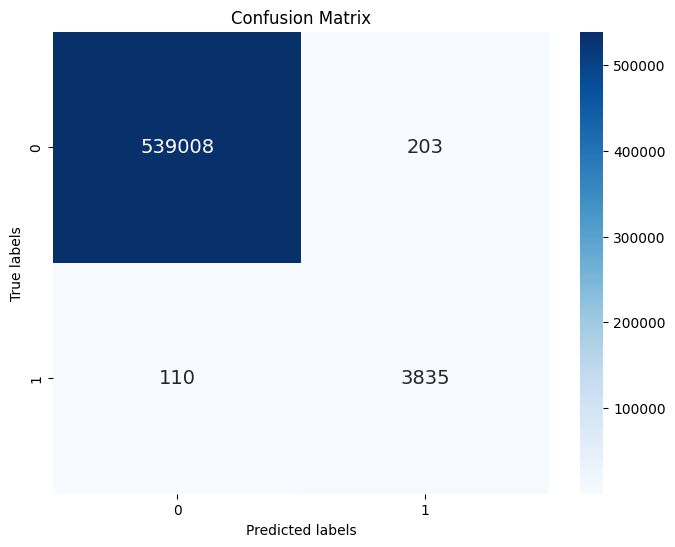

In [23]:
cm = confusion_matrix(y_test, predictions)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [24]:
report = classification_report(y_test, predictions)

# Display the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    539211
           1       0.95      0.97      0.96      3945

    accuracy                           1.00    543156
   macro avg       0.97      0.99      0.98    543156
weighted avg       1.00      1.00      1.00    543156



### Feature Importance <a class="anchor" id="seventh-bullet"></a>

The top four features according to XGBoost are: <br>

* submission_disposition_time_diff_days
* Division of Southwest Imports
* product_code_pic_encoded
* Division of Southeast Imports

In [28]:
xgb_model.get_score(importance_type='gain')

{'submission_disposition_time_diff_days': 317.1867370605469,
 'Division of Northeast Imports': 1.7896552085876465,
 'Division of Northern Border Imports': 1.4924501180648804,
 'Division of Southeast Imports': 3.014376640319824,
 'Division of Southwest Imports': 3.2568185329437256,
 'Division of West Coast Imports': 1.7143945693969727,
 'product_code_indust_encoded': 1.332914113998413,
 'product_code_class_encoded': 1.3626294136047363,
 'product_code_subclass_encoded': 1.5659962892532349,
 'product_code_pic_encoded': 3.20066237449646,
 'product_code_product_grp_encoded': 1.3524727821350098,
 'product_code_man_fei_encoded': 1.255963921546936}

<Axes: >

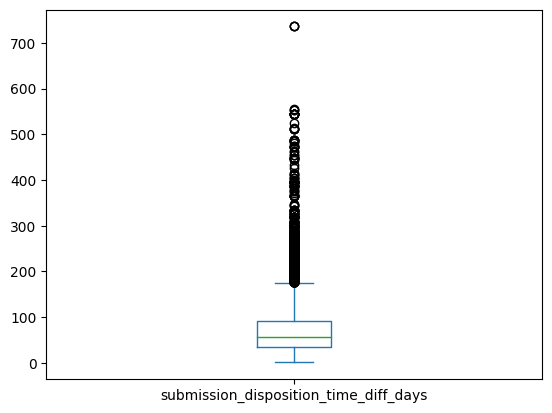

In [29]:
df[df['y'] == 1]['submission_disposition_time_diff_days'].plot(kind='box')

In [30]:
df[df['y'] == 1]['submission_disposition_time_diff_days'].mean()

71.91409452112087

<Axes: >

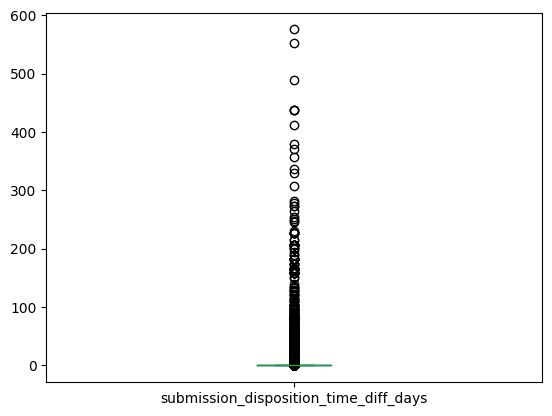

In [53]:
df[df['y'] == 0]['submission_disposition_time_diff_days'].plot(kind='box')

In [54]:
df[df['y'] == 0]['submission_disposition_time_diff_days'].mean()

0.28888036840322395